## 作業

1. 請比較使用不同層數以及不同 dropout ratio 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout ratio 檢視結果

## 參考資料

[理解 Dropout](https://blog.csdn.net/stdcoutzyx/article/details/49022443)

[Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD, Adam
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, dropout_ratios, optimizer_clz, optimizer_param,
                 neuron_numbers=(512, 256, 128,), epochs=50, batch_size=256):
    train_histories = []
    for i, dropout_ratio in enumerate(dropout_ratios):
        print('Experiment with dropout ratio: {:.2f}'.format(dropout_ratio))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers, dropout_ratio)
        model.summary()
        model.compile(optimizer=optimizer_clz(**optimizer_param),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, dropout_ratio):
    main_input, hidden_layer = Input(shape=input_shape, name='main_input'), None
    for i, neuron_number in enumerate(neuron_numbers):
        dense_layer = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')
        hidden_layer = dense_layer(hidden_layer) if hidden_layer is not None else dense_layer(main_input)
        hidden_layer = Dropout(dropout_ratio)(hidden_layer)
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_layer)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, dropout_ratios):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], dropout_ratios[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, dropout_ratio):
    plt.plot(train_history.history[train_name], '-', label='exp-dp-{:.2f}'.format(dropout_ratio), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp-dp-{:.2f}'.format(dropout_ratio), color=color)

## 以更多的隱藏層配合不同的移除率觀看學習曲線的走勢

In [7]:
## 設定超參數
dropout_ratios = (0.1, 0.2, 0.3, 0.5,)
neuron_numbers = (512, 256, 128, 64, 32, 16,)
optimizer_clz, optimizer_param = SGD, {'lr': 1e-3, 'momentum': 0.95, 'nesterov': True}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, dropout_ratios, optimizer_clz, optimizer_param,
                               neuron_numbers=neuron_numbers)

Experiment with dropout ratio: 0.10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 2.3002 - acc: 0.1112 - val_loss: 2.2652 - val_acc: 0.1664
Epoch 2/50
 - 12s - loss: 2.2401 - acc: 0.1491 - val_loss: 2.1527 - val_acc: 0.1964
Epoch 3/50
 - 12s - loss: 2.1731 - acc: 0.1710 - val_loss: 2.0905 - val_acc: 0.2256
Epoch 4/50
 - 13s - loss: 2.1319 - acc: 0.1848 - val_loss: 2.0466 - val_acc: 0.2290
Epoch 5/50
 - 12s - loss: 2.0971 - acc: 0.1983 - val_loss: 2.0131 - val_acc: 0.2630
Epoch 6/50
 - 13s - loss: 2.0635 - acc: 0.2158 - val_loss: 1.9687 - val_acc: 0.2813
Epoch 7/50
 - 12s - loss: 2.0303 - acc: 0.2247 - val_loss: 1.9201 - val_acc: 0.2926
Epoch 8/50
 - 12s - loss: 2.0028 - acc: 0.2348 - val_loss: 1.8968 - val_acc: 0.2936
Epoch 9/50
 - 12s - loss: 1.9724 - acc: 0.2507 - val_loss: 1.8621 - val_acc: 0.3139
Epoch 10/50
 - 12s - loss: 1.9580 - acc: 0.2542 - val_loss: 1.8410 - val_acc: 0.3118
Epoch 11/50
 - 12s - loss: 1.9343 - acc: 0.2641 - val_loss: 1.8209 - val_acc: 0.3254
Epoch 12/50
 - 12s - los

Epoch 21/50
 - 12s - loss: 1.9664 - acc: 0.2350 - val_loss: 1.8511 - val_acc: 0.2903
Epoch 22/50
 - 12s - loss: 1.9530 - acc: 0.2350 - val_loss: 1.8622 - val_acc: 0.2876
Epoch 23/50
 - 13s - loss: 1.9480 - acc: 0.2428 - val_loss: 1.8316 - val_acc: 0.2981
Epoch 24/50
 - 13s - loss: 1.9368 - acc: 0.2467 - val_loss: 1.8288 - val_acc: 0.2974
Epoch 25/50
 - 12s - loss: 1.9237 - acc: 0.2490 - val_loss: 1.8124 - val_acc: 0.2953
Epoch 26/50
 - 12s - loss: 1.9159 - acc: 0.2524 - val_loss: 1.7984 - val_acc: 0.3017
Epoch 27/50
 - 12s - loss: 1.9083 - acc: 0.2585 - val_loss: 1.7912 - val_acc: 0.3012
Epoch 28/50
 - 12s - loss: 1.9014 - acc: 0.2619 - val_loss: 1.7800 - val_acc: 0.3094
Epoch 29/50
 - 12s - loss: 1.9021 - acc: 0.2603 - val_loss: 1.7995 - val_acc: 0.3093
Epoch 30/50
 - 12s - loss: 1.8923 - acc: 0.2674 - val_loss: 1.7699 - val_acc: 0.3225
Epoch 31/50
 - 12s - loss: 1.8815 - acc: 0.2708 - val_loss: 1.7697 - val_acc: 0.3189
Epoch 32/50
 - 12s - loss: 1.8755 - acc: 0.2739 - val_loss: 1.763

Epoch 41/50
 - 12s - loss: 2.0960 - acc: 0.1730 - val_loss: 2.1062 - val_acc: 0.1616
Epoch 42/50
 - 12s - loss: 2.0873 - acc: 0.1773 - val_loss: 2.1439 - val_acc: 0.1536
Epoch 43/50
 - 12s - loss: 2.0884 - acc: 0.1773 - val_loss: 2.1342 - val_acc: 0.1557
Epoch 44/50
 - 12s - loss: 2.0847 - acc: 0.1749 - val_loss: 2.1275 - val_acc: 0.1553
Epoch 45/50
 - 12s - loss: 2.0864 - acc: 0.1771 - val_loss: 2.0857 - val_acc: 0.1715
Epoch 46/50
 - 12s - loss: 2.0923 - acc: 0.1750 - val_loss: 2.1244 - val_acc: 0.1578
Epoch 47/50
 - 12s - loss: 2.0946 - acc: 0.1733 - val_loss: 2.1149 - val_acc: 0.1616
Epoch 48/50
 - 12s - loss: 2.0844 - acc: 0.1783 - val_loss: 2.1195 - val_acc: 0.1576
Epoch 49/50
 - 12s - loss: 2.0791 - acc: 0.1796 - val_loss: 2.0980 - val_acc: 0.1658
Epoch 50/50
 - 12s - loss: 2.0753 - acc: 0.1817 - val_loss: 2.1086 - val_acc: 0.1608


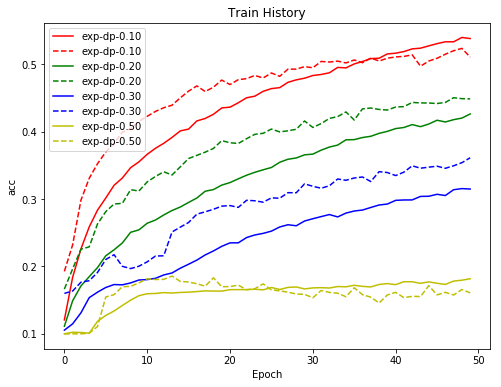

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, dropout_ratios)

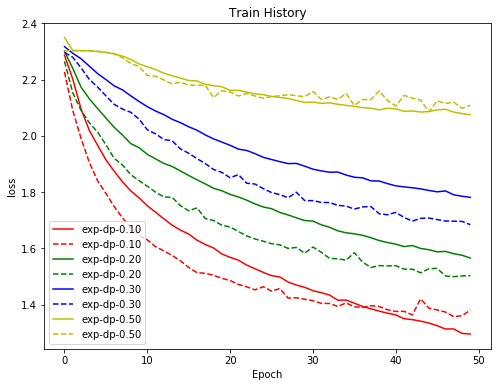

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, dropout_ratios)

## 以 Adam 優化器配合不同的移除率觀看學習曲線的走勢

In [11]:
## 設定超參數
dropout_ratios = (0.1, 0.2, 0.3, 0.5,)
neuron_numbers = (512, 256, 128,)
optimizer_clz, optimizer_param = Adam, {'lr': 1e-3}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y']

In [12]:
train_histories = train_models(X_train, y_train, X_test, y_test, dropout_ratios, optimizer_clz, optimizer_param,
                               neuron_numbers=neuron_numbers)

Experiment with dropout ratio: 0.10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)

Epoch 13/50
 - 15s - loss: 1.5741 - acc: 0.4358 - val_loss: 1.4966 - val_acc: 0.4664
Epoch 14/50
 - 15s - loss: 1.5623 - acc: 0.4390 - val_loss: 1.5111 - val_acc: 0.4577
Epoch 15/50
 - 15s - loss: 1.5564 - acc: 0.4415 - val_loss: 1.5118 - val_acc: 0.4638
Epoch 16/50
 - 15s - loss: 1.5407 - acc: 0.4474 - val_loss: 1.4847 - val_acc: 0.4691
Epoch 17/50
 - 15s - loss: 1.5361 - acc: 0.4492 - val_loss: 1.4628 - val_acc: 0.4793
Epoch 18/50
 - 15s - loss: 1.5273 - acc: 0.4536 - val_loss: 1.4815 - val_acc: 0.4684
Epoch 19/50
 - 15s - loss: 1.5234 - acc: 0.4535 - val_loss: 1.4508 - val_acc: 0.4768
Epoch 20/50
 - 15s - loss: 1.5061 - acc: 0.4590 - val_loss: 1.4823 - val_acc: 0.4670
Epoch 21/50
 - 15s - loss: 1.5120 - acc: 0.4566 - val_loss: 1.4625 - val_acc: 0.4805
Epoch 22/50
 - 15s - loss: 1.4904 - acc: 0.4647 - val_loss: 1.4644 - val_acc: 0.4734
Epoch 23/50
 - 15s - loss: 1.4993 - acc: 0.4605 - val_loss: 1.4564 - val_acc: 0.4821
Epoch 24/50
 - 15s - loss: 1.4839 - acc: 0.4657 - val_loss: 1.481

 - 15s - loss: 1.5963 - acc: 0.4230 - val_loss: 1.5486 - val_acc: 0.4565
Epoch 43/50
 - 15s - loss: 1.5915 - acc: 0.4239 - val_loss: 1.5489 - val_acc: 0.4504
Epoch 44/50
 - 15s - loss: 1.5920 - acc: 0.4263 - val_loss: 1.5530 - val_acc: 0.4491
Epoch 45/50
 - 15s - loss: 1.5875 - acc: 0.4262 - val_loss: 1.5470 - val_acc: 0.4525
Epoch 46/50
 - 15s - loss: 1.5903 - acc: 0.4278 - val_loss: 1.5452 - val_acc: 0.4554
Epoch 47/50
 - 15s - loss: 1.5847 - acc: 0.4303 - val_loss: 1.5788 - val_acc: 0.4481
Epoch 48/50
 - 15s - loss: 1.5844 - acc: 0.4282 - val_loss: 1.5413 - val_acc: 0.4608
Epoch 49/50
 - 15s - loss: 1.5751 - acc: 0.4315 - val_loss: 1.5429 - val_acc: 0.4556
Epoch 50/50
 - 15s - loss: 1.5763 - acc: 0.4289 - val_loss: 1.5428 - val_acc: 0.4568
Experiment with dropout ratio: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_____________

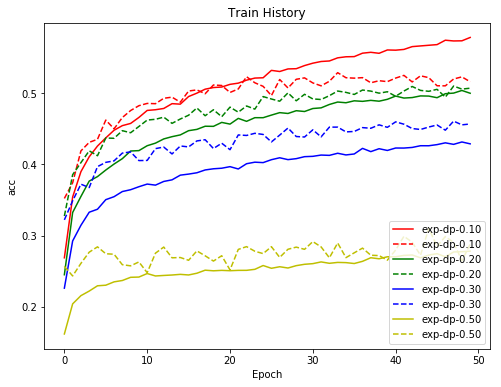

In [13]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, dropout_ratios)

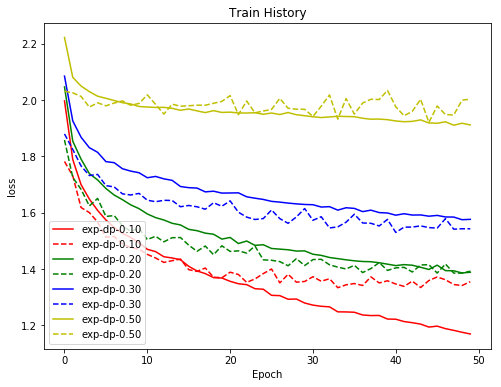

In [14]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, dropout_ratios)